- 목차

- 1. 데이터 확인
- 2. 전처리 (Preprocessing)
- 3. 데이터 분할 (Data Split)
- 4. 이상치 처리 (Outlier Handling)
- 5. Feature Selection + Logistic Regression
- 6. Tree 기반 모델
- 7. Neural Network 모델 개발
- 8. 프로젝트 최종 결론 /  대출 수용 가능 고객의 행동 패턴

### 0. 환경 설정

In [1]:
!apt-get update -qq
!apt-get install -y fonts-nanum

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# 폰트 캐시 제거 (중요)
cache_dir = os.path.expanduser('~/.cache/matplotlib')
if os.path.exists(cache_dir):
    os.system(f'rm -rf {cache_dir}')

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 81 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.4 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
# 런타임 재시작
!apt-get update -qq
!apt-get -qq install -y fonts-nanum
import os
os.kill(os.getpid(),9)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
# =========================
# 0. 환경 세팅
# =========================
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest, f_classif

# XGBoost (Colab에서 보통 사용 가능)
from xgboost import XGBClassifier

# (선택) Borderline-SMOTE
from imblearn.over_sampling import BorderlineSMOTE

# VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# Nanum 폰트 경로 확인
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# matplotlib 전역 설정
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

print("현재 설정된 폰트:", font_prop.get_name())

print("한글 폰트 설정 완료")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


현재 설정된 폰트: NanumGothic
한글 폰트 설정 완료


## 1. 데이터 확인

본 데이터는 「서울시민 라이프스타일 재현 데이터」 중  
*소비 및 이동 패턴 재현 데이터*를 사용한다.

#### 데이터 특징
- 개인 단위의 라이프스타일 정보를 기반으로 구성된 행동 데이터
- 주민등록 기반 정보와 실제 행동 로그 성격의 변수가 함께 포함됨
  - 인구통계 정보: 생년월일, 성별, 자치구명, 세대주여부 등
  - 행동 정보: 카드 소비, 이동 패턴, 통신 이용, 생활 반경 등

#### 타깃 변수
- 대출여부 : 이진 분류 문제 (0: 비대출, 1: 대출)

#### 분석 시 유의사항
- 일부 변수는 행정 정보(정적 특성),
  일부 변수는 소비·이동과 같은 행동 정보(동적 특성)로 성격이 다르다.
- `생년월일` 컬럼은 날짜 타입이 아닌  
  **연도(4자리 정수)** 형태로 제공되는 경우가 존재한다.
  - 예: 1987

이러한 특성을 고려하여, 이후 전처리 단계에서는 변수의 의미와 생성 시점을 기준으로 적절한 변환 및 정제를 수행한다.


### 1-1. 데이터 로드

In [ ]:
# CSV 파일을 불러와 데이터의 기본 구조를 확인하는 가장 첫 단계

#데이터 파일 경로 지정
# 불러올 CSV 파일의 경로와 파일명을 문자열로 지정
# Google Colab 기준: 파일을 업로드하면 보통 현재 작업 디렉토리에 위치

data_path = "서울 시민의 소비 및 이동 패턴 재현 데이터.csv"  # Colab 업로드 후 경로
df_raw = pd.read_csv(data_path)  # CSV 파일 읽기

print("shape:", df_raw.shape)  # 데이터 크기 확인, df_raw.shape:(행 개수, 컬럼 개수) 반환
df_raw.head()  # 데이터 미리보기


NameError: name 'pd' is not defined

### 1-2. 기본 점검

- 데이터의 전체 구조와 타깃 변수(대출여부)의 분포를 점검하는 초기 EDA(탐색적 분석) 단계
- 데이터 전체 구조(info)를 통해 컬럼 타입과 결측 상태를 점검하고,
- 타깃 변수(대출여부)의 개수와 비율을 확인하여
- 클래스 불균형 및 데이터 품질을 진단하는 초기 EDA 단계

In [ ]:
df_raw.info()  # 데이터프레임의 요약 정보

print("\n타깃 분포(대출여부):")
display(df_raw["대출여부"].value_counts(dropna=False))  # 타깃 변수 분포 확인 (개수), dropna=False:결측치(NaN)도 함께 집계
display(df_raw["대출여부"].value_counts(normalize=True, dropna=False))   # 타깃 변수 분포 확인 (비율)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 103 entries, Unnamed: 0 to 지하철_이동일수
dtypes: float64(52), int64(48), object(3)
memory usage: 804.8+ KB

타깃 분포(대출여부):


,count
대출여부,
1,530
0,470


,proportion
대출여부,
1,0.53
0,0.47


## 2. 전처리 (Preprocessing)

본 데이터의 결측치는 단순한 “누락”이 아니라 변수의 성격에 따라 의미(상태)를 내포할 수 있습니다.
##### (1) 0으로 대체하는 결측치
다음과 같은 행동/이용량(활동량) 계열 변수의 NaN은  
대부분 “관측이 안 된 것”이 아니라 “해당 활동이 없었다”로 해석하는 것이 자연스럽다.

- 이용량/횟수/대상자수
- 이동거리/이동속도
- 소비 비중(가맹점 분류 비중 등)

따라서 이 범주의 NaN은 0으로 대체하여 처리합니다.

##### (2) 0으로 대체하면 안 되는 결측치 (예외)
반면 소득 계열 변수의 NaN은 0으로 채우면 안 됩니다.

- `추정연소득`
- `추정연소득_백분위`

이유:
- 소득이 0이라는 값은 현실적으로 타당하지 않으며,
- NaN을 0으로 대체하면 모델이 이를 “극단적으로 낮은 소득”으로 오해해
  분포가 심하게 왜곡될 수 있습니다.

따라서 소득 계열은 다음 단계에서  
결측 플래그 생성 + 중앙값 대치 + log 변환 방식으로 별도 처리합니다.


### 2-1. 결측치 처리: "활동/이용량" 계열 NaN → 0


In [ ]:
#  추정연소득, 추정연소득_백분위는 다음 셀에서 별도 처리

zero_fill_columns = [
    "평균_문자대상자수",
    "평균_통화대상자수",
    "평균_통화량",
    "가맹점분류_이용비중1",
    "가맹점분류_이용비중2",
    "가맹점분류_이용비중3",
    "가맹점분류_이용비중4",
    "가맹점분류_이용비중5",
    "가맹점분류_이용비중6",
    "가맹점분류_이용비중7",
    "가맹점분류_이용비중8",
    "가맹점분류_이용비중9",
    "가맹점분류_이용비중10",
    "가맹점분류_이용비중11",
    "가맹점분류_이용비중12",
    "가맹점분류_이용비중13",
    "가맹점분류_이용비중14",
    "가맹점분류_이용비중15",
    "가맹점분류_이용비중16",
    "가맹점분류_이용비중17",
    "가맹점분류_이용비중18",
    "가맹점분류_이용비중19",
    "평일_이동_총횟수",
    "휴일_이동_총횟수",
    "평일_총이동거리",
    "평일_이동속도_평균",
    "휴일_총이동거리",
    "휴일_이동속도_평균",
    "택시이용_이동횟수",
    "네비게이션이용_이동횟수",
    "지하철_이동일수"
]

# 데이터프레임 전체에서 결측치(NaN)가 차지하는 비율(결측률)을 계산
# df_raw.isna() : df_raw의 각 원소가 결측치인지 여부를 검사,  결과는 True / False로 이루어진 DataFrame. 결측치(NaN) → True, 정상값 → False
# .sum().sum() :첫 번째 sum() → 열(column)별로 True의 개수를 셉니다. (True는 1, False는 0으로 계산됨)
# 두 번째 sum() :→ 모든 열의 결측치 개수를 다시 합쳐서 데이터프레임 전체 결측치 개수를 구합니다
# df_raw.size ; 데이터프레임의 전체 원소 개수 계산식: 행 개수 × 열 개수
missing_rate_before = df_raw.isna().sum().sum() / df_raw.size
print("처리 전 전체 결측률:", round(missing_rate_before * 100, 2), "%") #결측률 계산:missing_rate_before = 전체 결측치 개수 / 전체 데이터 개수

# 결측치 값의 범위: 0 ~ 1

처리 전 전체 결측률: 8.67 %


- 1) 일부 컬럼의 결측치를 0으로 대체한 뒤,
- 2) 전체 결측률이 얼마나 줄었는지 확인하고
- 3) 아직 결측치가 남아 있는 컬럼을 점검하는 과정

In [ ]:
# 결측치를 0으로 치환
df_raw[zero_fill_columns] = df_raw[zero_fill_columns].fillna(0)  # zero_fill_columns: 결측치를 0으로 채우기로 결정한 컬럼 리스트

# 처리 후 전체 결측률
missing_rate_after = df_raw.isna().sum().sum() / df_raw.size
print("처리 후 전체 결측률:", round(missing_rate_after * 100, 2), "%")

# 다음 셀에서 처리할 결측 컬럼이 남아있는지 확인(2개만 남아야 정상)
# df_raw.isna().sum() : 각 컬럼별 결측치 개수 계산
# .sort_values(ascending=False) ; 결측치가 많은 컬럼부터 내림차순 정렬
# .head(20) : 결측치가 가장 많은 상위 20개 컬럼만 출력
# display(...) :Jupyter Notebook에서 표 형태로 가독성 있게 출력

print("\n결측이 남아있는 컬럼(상위 20개):")
display(df_raw.isna().sum().sort_values(ascending=False).head(20))

처리 후 전체 결측률: 0.1 %

결측이 남아있는 컬럼(상위 20개):


,0
추정연소득,49
추정연소득_백분위,49
Unnamed: 0,0
성별,0
동일세대_학령기인구수,0
자치구명,0
생년월일,0
직업군,0
동일세대_미취학아동수,0
평균_문자대상자수,0


### 2-2. 소득 전처리: 백분위 제거 + 결측 플래그 + 중앙값 + 로그 변환

#### (1) 변수 의미
- `추정연소득`: 연 소득을 추정한 값(원 단위)
- `추정연소득_백분위`: `추정연소득`의 **상대적 위치(순위)** 를 나타내는 값

#### (2) 왜 NaN을 0으로 채우면 안 되나?
소득 0은 정상 범위가 아니며, NaN을 0으로 채우면 모델이 이를 “극단적으로 낮은 소득”으로 오해할 수 있습니다.

#### (3) 왜 로그 변환을 하나?
소득/자산은 한쪽으로 치우친 분포인 경우가 많아 log` 변환을 하면 분포가 더 안정적(정규분포에 가까운 형태)으로 바뀌는 경우가 많습니다.

#### (4) 백분위는 왜 제거해도 되나?
`log(추정연소득)`은 순위(백분위) 정보와 중복되는 부분이 많아,  
이번 프로젝트에서는 `log_추정연소득`만 남기고 `추정연소득_백분위`는 제거합니다.

#### (5) NaN은 무엇으로 채우나?
NaN이 “소득이 0”이라는 뜻은 아니므로,
- 상태 정보**는 `추정연소득_미추정여부`(플래그)로 남기고,
- 숫자 값**은 모델 계산을 위해 **중앙값(median)으로 보완합니다.

#### (6) `추정연소득_미추정여부`는 무엇을 의미하나?
`추정연소득_미추정여부`는 소득이 낮은지 여부가 아니라, 소득 추정 자체가 불안정하거나 어려운 상태를 의미합니다.

이는 다음과 같은 상황을 포함할 수 있습니다.
- 소비·금융·이동 패턴이 충분하지 않은 경우
- 외부 정보와의 매칭이 약한 경우
- 추정 모델의 적용 범위를 벗어난 고객

즉, 이 변수는 “얼마를 버는가”가 아니라  
“이 고객의 소득 정보를 얼마나 신뢰할 수 있는가” 를 나타내는 지표입니다.

마케팅 관점에서는
- 소득이 높은 고객보다
- 소득이 ‘명확하게 파악되는’ 고객이 더 안정적인 타깃이 되는 경우도 많습니다.

따라서 본 프로젝트에서는  
소득의 크기(`log_추정연소득`)와  
소득 추정의 안정성(`추정연소득_미추정여부`)을 분리하여 모델에 입력합니다.

In [ ]:
# 추정연소득 변수 하나를 모델 친화적으로 전처리하는 전체 파이프라인

# 1) 백분위 컬럼 제거 : 중복 피처 제거 , 모델 입력 변수를 더 단순하고 명확하게 유지
# 특정 컬럼이 존재할 때만 안전하게 삭제하는 방어적 전처리 코드
# if "추정연소득_백분위" in df_raw.columns:데이터프레임 df_raw에 추정연소득_백분위라는 컬럼이 실제로 존재하는지 확인
if "추정연소득_백분위" in df_raw.columns:
    df_raw = df_raw.drop(columns=["추정연소득_백분위"])  # 컬럼 삭제 : 해당 컬럼을 데이터프레임에서 제거

# 2) 결측 여부 플래그 생성(해석용)
# 원래 소득이: 결측(NaN) → 1, 존재 → 0
# 왜 필요한가? : “소득이 낮음”과 “소득 정보 자체가 없음”은 전혀 다른 신호, 결측 자체가 중요한 행동/속성 정보일 수 있음
# 효과 : 모델이 결측 패턴 자체를 학습 가능
# ✔ 해석 시: “소득 미추정 고객은 ○○한 특성이 있다”

df_raw["추정연소득_미추정여부"] = df_raw["추정연소득"].isna().astype(int)

# 3) NaN → 중앙값으로 보완(모델 계산용)
# 평균(mean) 대신 중앙값(median) 사용 이유: 소득 데이터는 오른쪽으로 치우친 분포, 극단값(outlier)에 강건함

income_median = df_raw["추정연소득"].median()
df_raw["추정연소득"] = df_raw["추정연소득"].fillna(income_median)

# 4) 로그 변환
# log1p(x) : log(1 + x) --> 0 값도 안전하게 변환 가능
# 로그 변환 효과:✔ 분포 왜도 감소,✔ 극단값 영향 완화,✔ 선형/시계열 모델 안정성 증가

df_raw["log_추정연소득"] = np.log1p(df_raw["추정연소득"])

# 5) 원본 소득 컬럼 제거
# 원본 컬럼과 로그 컬럼을 동시에 두면:정보 중복, 스케일 차이로 모델 불안정
df_raw = df_raw.drop(columns=["추정연소득"])

# 처리 후 전체 결측률 확인(전체 데이터 기준)
# 목적:✔ 소득 관련 결측치가 완전히 처리되었는지 검증, ✔ 다른 컬럼에 예상치 못한 NaN이 남아 있는지 확인
missing_rate_after = df_raw.isna().sum().sum() / df_raw.size
print("소득 전처리 후 전체 결측률:", round(missing_rate_after * 100, 2), "%")


소득 전처리 후 전체 결측률: 0.0 %


### 2-3. 0 전처리: Zero-Inflated Distribution(영(0) 과다 분포) 처리

데이터에 0 값이 “비정상적으로 많이” 등장하는 분포
일부 소비 관련 변수(예: 배달비용, 편의점 이용금액 등)는  
값의 분포가 0에 크게 몰리고, 소수의 양수 값만 존재하는 형태를 보인다.  
이러한 분포를 *Zero-Inflated Distribution*이라고 한다.

#### 왜 별도 처리가 필요한가?
이 경우 `0`은 단순한 결측치가 아니라, 해당 소비 행위를 전혀 하지 않았음을 의미할 가능성이 매우 높다.

예를 들어,
- 배달비용이 `0`인 경우는  “데이터가 비어 있음”이 아니라 “배달 서비스를 이용하지 않은 사용자”일 확률이 높다.

#### 처리 전략
따라서 이러한 변수들은 `추정연소득`과 유사하게 다음과 같이 처리한다.
실무에서의 대표적인 대응 방법:  (1) Flag + 금액 분리 (가장 많이 씀)

- 소비 금액이 `0`인지 여부를 나타내는 Flag 변수를 생성
- #### Flag 변수: 어떤 조건을 만족하는지 여부만 표시하는 이진 변수,  보통 값은:1 → 조건을 만족함, 0 → 조건을 만족하지 않음
- 로그 변환 시 특히 중요:로그 변환, log(0) → 불가능, log1p(0) = 0, 로그 후에는:0원 소비
- 아주 적은 소비가 더 비슷해짐==> Flag가 없으면 “무소비” 정보가 사라짐
- 원본 금액 변수는 모델에 직접 사용하지 않거나, 보조 정보로만 활용
- 이를 통해 모델이 “얼마를 썼는가”보다는  “해당 소비 행위를 했는가/하지 않았는가”를 먼저 학습하도록 유도할 수 있다.
- 이러한 방식은 해석 가능성을 높이고, 소비 행동 기반 마케팅 인사이트 도출에도 유리하다.

- “소비/이용 금액이 0인지 아닌지”를 행동 신호로 분리하기 위해 이진 Flag 변수를 대량 생성하는 전처리 로직

- 소비/이용금액 계열 → 이용 여부 flag 생성
- 1: 해당 소비/이용을 한 경우
- 0: 해당 소비/이용을 하지 않은 경우

In [ ]:
# Flag 생성 대상 컬럼 정의
# 0이 ‘의미 있는 값’인 금액 컬럼들만 선별: 0 → 해당 기간에 이용/소비 없음,  > 0 → 행동 발생
# “얼마를 썼는가” 이전에 “썼는가 / 안 썼는가”가 중요한 변수들
flag_target_cols = [
    # 카드 이용/소비
    "카드소비금액",
    "신용카드소비금액",
    "체크카드소비금액",
    "일시불이용금액",
    "할부이용금액",
    "현금서비스이용금액",
    "해외카드이용금액",
    "온라인_카드사용_금액",
    "오프라인_카드사용_금액",
    "가맹점합산이용금액",

    # 채널/상황별 소비
    "배달앱_이용금액",
    "마케팅_편의점_이용금액",
    "마케팅_슈퍼마켓_이용금액",
    "마케팅_온라인쇼핑_이용금액",
    "마케팅_소셜커머스_이용금액",
    "제주도지역_이용금액",
    "해외여행_이용금액"
]

# 0 여부 flag 생성
# (df_raw[col] > 0) : 조건 비교 결과 금액 > 0 → True, 0 또는 음수 → False
# .astype(int) : True → 1,  False → 0
# 결과: {원본금액컬럼}_이용여부,  1 → 해당 항목 이용함,  0 → 이용 안 함

for col in flag_target_cols:
    flag_col_name = f"{col}_이용여부"   # Flag 컬럼 이름 규칙, 원본 변수와 1:1 매칭

# 해석 시 직관적:배달앱_이용금액 + 배달앱_이용금액_이용여부
# 모델 설명, SHAP, 리포트에 매우 유리

    df_raw[flag_col_name] = (df_raw[col] > 0).astype(int)

print("생성된 flag 컬럼 수:", len(flag_target_cols))
print("flag 예시:")
display(df_raw[[flag_target_cols[0], f"{flag_target_cols[0]}_이용여부"]].head())


생성된 flag 컬럼 수: 17
flag 예시:


,카드소비금액,카드소비금액_이용여부
0,7996,1
1,1625,1
2,249,1
3,9078,1
4,1347,1


### 2-4. 데이터 변환: 생년월일 → 나이 (기준 연도: 2022년)

전처리 과정에서의 데이터 변환(Data Transformation) 은 단순히 로그 변환(log transform)만을 의미하지 않는다.

이 섹션에서는 날짜 정보를 **의미 있는 수치형 변수로 바꾸는 대표적인 예로  
`생년월일 → 나이(age)` 변환을 수행한다.

#### 왜 생년월일을 그대로 사용하지 않는가?
- 생년월일은 모델이 직접 해석하기 어려운 형태의 변수이며,
- 연·월·일 단위의 정보는 본 프로젝트의 분석 목적에 비해 과도하다.
- 실제 마케팅·금융 분석에서는  
  **절대적인 날짜보다 ‘연령’이 더 직관적이고 설명력이 높은 변수**로 사용된다.

따라서 생년월일을 나이로 변환함으로써,
- 모델의 해석 가능성을 높이고
- 연령대에 따른 소비·금융 행동 패턴을 더 명확하게 학습할 수 있다.

#### 기준 연도를 2022년으로 설정한 이유
나이 계산의 기준 연도는 **2022년**으로 고정한다.

이는 본 데이터가  
**2022년 3분기 시점을 기준으로 수집·재현된 데이터**이기 때문이다.

즉,
- 예측 시점에서 실제로 알 수 있었던 정보만을 사용하기 위해
- 데이터 수집 이후의 미래 정보가 암묵적으로 반영되는 것을 방지하기 위함이다.

이처럼 기준 시점을 명확히 고정하는 것은
- 데이터 누수(Data Leakage)를 방지하고
- 현실적인 분석 환경을 모사하는 데 매우 중요하다.

이 변환을 통해,
`생년월일`이라는 원시 데이터를  
모델이 이해할 수 있는 **연속형 수치 변수(나이)** 로 변환한다.


In [ ]:
# =========================
# 2-4. 데이터 변환: 생년월일 → 나이
# =========================

# 생년월일이 ‘출생 연도’ 형태로 들어온 경우,: 이를 나이(age) 변수로 변환하고 원본 컬럼을 제거하는 전처리
# 생년월일이 1987 처럼 '연도'로 들어온다고 가정
# df_raw["생년월일"].astype(int) : 생년월일이:문자열 "1987" 이거나,float 1987.0 인 경우를 대비 정수형 연도로 변환
#  current_year - 출생연도
# 나이 계산 공식: 나이 ≈ 기준연도 - 출생연도
# 월/일 정보가 없으므로: 만 나이 아님, 연 나이(대략적인 나이), 모델링에서는 이 방식이 충분하고 안정적
current_year = 2022  # 데이터 수집 시점(2022년 3분기 기준)
df_raw["나이"] = current_year - df_raw["생년월일"].astype(int)  # 생년월일(연도) → 나이 계산

# 원본 생년월일 컬럼 제거: 생년월일(연도)와 나이는 완전히 중복 정보,모델 입력에 둘 다 두면:다중공선성,해석 혼란,불필요한 차원 증가
df_raw.drop(columns=["생년월일"], inplace=True)


### 2-5. Data Leakage 제거: 대출/약정 금액 컬럼 삭제

#### 다음 컬럼들은 대출 여부를 예측하는 문제에서 예측 타깃(`대출여부`)과 직접적으로 연결될 수 있는 변수들이다.

- `총대출약정금액`
- `주택담보대출약정금액`
- `신용대출약정금액`
- `자동차대출약정금액`
- `연체여부`

#### 왜 문제가 되는가? (Data Leakage)
데이터 누수(Data Leakage)란, 모델이 예측 시점에는 알 수 없는 정보가 학습에 사용되는 현상을 의미한다.

위 변수들은 모두
- 이미 대출이 실행되었거나
- 대출 약정이 체결된 이후에만 관측 가능한 값들이다.

즉,
> 해당 값이 존재한다는 사실 자체가  
> 이미 ‘대출 여부’를 매우 강하게 암시한다.

이러한 변수를 그대로 사용하면,
- 모델은 실제로는 미래를 예측하는 것이 아니라 정답을 거의 그대로 참고하게 된다.

그 결과,
- 학습·검증 성능은 비정상적으로 높아지지만
- 실제 환경에서는 전혀 일반화되지 않는 모델이 만들어진다.

#### 처리 방침
본 프로젝트의 목적은
- “이미 대출이 있었는가”를 맞히는 것이 아니라,
- "대출을 수용할 가능성이 있는 고객의 행동 패턴을 설명하는 것"이다.

따라서 위 대출/약정 관련 컬럼들은 데이터 누수를 방지하기 위해 전부 제거한다.

이를 통해 모델은
- 소득, 소비, 이동, 생활 패턴과 같은 대출의 ‘원인 후보’ 정보만을 기반으로 학습하게 된다.


In [ ]:
# 대출 결과 또는 사후 정보에 해당하는 변수들
# 공통 특징:대출이 실행된 이후에 결정됨,또는 타깃과 강한 인과/상관 관계--> 예측 모델에 넣으면 feature leakage 발생

loan_related_cols = [
    "총대출약정금액",
    "주택담보대출약정금액",
    "신용대출약정금액",
    "자동차대출약정금액",
    "연체여부"
]

# 실제 존재하는 컬럼만 선별: 없는 컬럼을 drop하면 에러 발생
existing_loan_cols = [c for c in loan_related_cols if c in df_raw.columns]

# 삭제 대상 확인 출력
# 목적 ;✔ 어떤 컬럼이 실제로 제거되는지 명시적 확인, ✔ 전처리 로그 기록용, ✔ 실수로 중요한 컬럼을 제거하지 않았는지 점검
print("삭제 대상 대출 관련 컬럼:")
print(existing_loan_cols)

df_raw = df_raw.drop(columns=existing_loan_cols)   # Data Leakage 가능성이 있는 컬럼 완전 제거

print("대출/약정 관련 컬럼 제거 완료") # 전처리 단계 정상 종료 알림, 컬럼 수 변화를 통해: 삭제가 실제로 적용되었는지 확인
print("현재 컬럼 수:", df_raw.shape[1]) # 데이터프레임 df_raw에 현재 몇 개의 컬럼(변수)이 있는지 출력하는 코드, (행 개수, 컬럼 개수)
# 전처리 이후: 컬럼 삭제, 컬럼 생성,파생 변수 추가 등이 정상적으로 반영되었는지 확인


삭제 대상 대출 관련 컬럼:
['총대출약정금액', '주택담보대출약정금액', '신용대출약정금액', '자동차대출약정금액', '연체여부']
대출/약정 관련 컬럼 제거 완료
현재 컬럼 수: 115


## 3. 데이터 분할 (Data Split)

전처리가 완료된 데이터(`df_raw`)를 바탕으로 모델 학습을 위한 입력 데이터를 구성한다.
모델 학습을 위해 데이터셋을 피처(X)와 타깃(y)으로 분리하는 표준적인 단계

이 분리를 명확히 해두면,이후 단계에서
- 학습/검증/테스트 분할,
- 이상치 처리(Winsorizing),
- 표준화(Standardization),
- 모델 학습 및 평가가 모두 일관된 흐름으로 진행된다.


### 3-1. 타깃(y) / 피처(X) 분리

In [ ]:
# 원본 데이터 복사
df = df_raw.copy()  # df_raw를 그대로 보존하기 위해 복사본 생성

# 타깃변수(y) 생성: 대출여부 (0/1)
# 예측하고 싶은 목표 변수:대출여부 (이진 분류)0 → 미대출,1 → 대출
# astype(int) ; 혹시 모를:True / False  0.0 / 1.0, 문자열 "0" / "1"등을 명확한 정수형(0/1) 으로 통일
y = df["대출여부"].astype(int)

# 피처 변수(X) 생성: 타깃 컬럼 제거
# 타깃이 피처에 포함되면 Data Leakage,  모델이 정답을 보고 학습하게 됨, 반드시 타깃 컬럼은 X에서 제거해야 함
X = df.drop(columns=["대출여부"])

print("X shape:", X.shape, "| y shape:", y.shape)  # 데이터 크기 확인,  컬럼 수:X → 피처 개수, y → 1차원 벡터
X.head()  # 피처 데이터의 상위 5개 행 미리보기


X shape: (1000, 114) | y shape: (1000,)


,Unnamed: 0,자치구명,성별,동일세대_학령기인구수,동일세대_미취학아동수,직업군,평균_문자대상자수,평균_통화대상자수,평균_통화량,세대주여부,...,오프라인_카드사용_금액_이용여부,가맹점합산이용금액_이용여부,배달앱_이용금액_이용여부,마케팅_편의점_이용금액_이용여부,마케팅_슈퍼마켓_이용금액_이용여부,마케팅_온라인쇼핑_이용금액_이용여부,마케팅_소셜커머스_이용금액_이용여부,제주도지역_이용금액_이용여부,해외여행_이용금액_이용여부,나이
0,0,강동구,남,3,0,420,0.0,0.0,0.0,세대주,...,1,1,1,1,1,1,0,0,0,44
1,1,도봉구,남,2,0,420,0.0,0.0,0.0,세대주,...,1,1,0,0,0,0,0,0,0,79
2,2,동작구,남,2,0,420,0.0,0.0,0.0,세대주,...,0,0,0,0,0,0,0,0,0,66
3,3,동대문구,여,2,0,420,0.0,0.0,0.0,세대주,...,1,1,1,0,0,0,0,0,0,43
4,4,서초구,여,0,0,420,28.0,6.0,91.0,세대주,...,1,1,0,0,0,0,0,0,0,81


### 3-2. 층화 추출(Stratified Split)을 적용한 데이터 분할

- 본 프로젝트에서는 Train / Validation / Test 데이터를 분할할 때 층화 추출(stratify) 방식을 사용한다.
- 이는 타깃 변수인 `대출여부`의 비율이 각 데이터셋(Train / Validation / Test)에서 유사하게 유지되도록 하기 위함이다.
- 대출 여부와 같은 이진 분류 문제에서는 데이터 분할 과정에서 클래스 비율이 크게 달라질 경우,
- 모델 성능 평가가 왜곡되거나
- 특정 데이터셋에서 한 클래스가 과도하게 많거나 적어질 수 있다.
- 따라서 `stratify=y` 옵션을 사용하여, 학습 데이터와 검증·테스트 데이터가동일한 분포 조건을 가지도록 분할한다.
- 이를 통해 모델 성능 비교와 해석을 보다 안정적인 조건에서 수행할 수 있다.

- Train / Validation / Test = 6 : 2 : 2 비율로 계층적(stratified) 분할하는 표준적인 절차

In [ ]:
from sklearn.model_selection import train_test_split

# 1단계: Train(60%) / Temp(40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,  # 전체의 40%를 Temp로 분리
    stratify=y,  # stratify=y 타깃 비율(대출여부 0/1)을 Train / Temp 모두에서 동일하게 유지
    random_state=RANDOM_STATE   # random_state=RANDOM_STATE  난수 고정 → 실험 재현성 확보
)

# 2단계: Validation(20%) / Test(20%)
# Temp(40%)를 다시: Validation: 20%, Test: 20%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

# 분할 결과 확인
print("Train :", X_train.shape, y_train.shape)
print("Valid :", X_val.shape, y_val.shape)
print("Test  :", X_test.shape, y_test.shape)

# 타깃 클래스 비율 확인
# 각 데이터셋에서: 0 / 1 비율이 거의 동일해야 정상  normalize=True: 개수 → 비율(확률) 로 출력
print("\n[대출여부 비율]")
print("Train:\n", y_train.value_counts(normalize=True))
print("Valid:\n", y_val.value_counts(normalize=True))
print("Test:\n", y_test.value_counts(normalize=True))


Train : (600, 114) (600,)
Valid : (200, 114) (200,)
Test  : (200, 114) (200,)

[대출여부 비율]
Train:
 대출여부
1    0.53
0    0.47
Name: proportion, dtype: float64
Valid:
 대출여부
1    0.53
0    0.47
Name: proportion, dtype: float64
Test:
 대출여부
1    0.53
0    0.47
Name: proportion, dtype: float64


## 4. 이상치 처리 (Outlier Handling)

모델링에 앞서, 수치형 변수들에 극단적으로 큰 값(outlier) 이 존재하는지 점검하고, 필요한 경우 이를 완화한다.

#### 왜 이상치 처리가 필요한가?
소득, 소비, 이용금액과 같은 변수들은
- 일부 소수의 고객에게서 매우 큰 값이 관측되는 경우가 많다.
- 이러한 극단값은 평균, 분산과 같은 통계량을 왜곡하고,
- 특히 선형 모델(Logistic Regression) 에서 계수 추정에 과도한 영향을 줄 수 있다.

#### 이상치는 항상 제거해야 하는가?
반드시 그렇지는 않다.
- 이상치는 실제로 존재하는 현실적인 행동일 수도 있고,
- 트리 기반 모델(RandomForest, XGBoost)은 이상치에 비교적 강건하다.

따라서 본 프로젝트에서는
- 이상치를 “제거”하기보다는 **극단적인 영향만 완화(clipping) 하는 전략을 사용한다.

#### 처리 전략
- 수치형 변수들의 분포와 요약 통계를 먼저 확인하고,
- 이후 상·하위 극단값을 제한하는 Winsorizing 기법을 적용한다.
- 처리 전·후 분포를 비교하여, 분포가 과도하게 왜곡되지 않았는지 함께 확인한다.

이 단계의 목적은
> “완벽하게 정규분포를 만드는 것”이 아니라  
> 모델이 안정적으로 학습할 수 있는 범위로 값을 정리하는 것이다.


Train 데이터 기준으로
1. 결측치가 얼마나 남아 있는지 점검하고
2. 수치형 변수의 분포를 요약하여 이상치(outlier) 여부를 탐색하는 모델 학습 전 최종 데이터 품질 점검 단계

### 4-1. 이상치 처리 전 상태 확인 (Train 기준)

- 이 코드는 Train 데이터만 사용하여 남아 있는 결측치를 점검하고,수치형 변수의 분포와 이상치를 사전에 탐색하는
- 모델 학습 전 필수 데이터 품질 검증 단계

In [ ]:
# 결측률 확인 (train 기준)
missing_ratio = (X_train.isna().mean().sort_values(ascending=False) * 100).round(2)
display(missing_ratio.head(15))

# 수치형 변수만 요약 통계 (이상치 감지용) : 평균, 표준편차, min/max 같은 통계량은 수치형 변수에서만 의미 있음
numeric_cols_all = X_train.select_dtypes(include=[np.number]).columns.tolist()
# 수치형 변수 요약 통계 출력
# .describe() :각 수치형 컬럼에 대해:  count, mean, std, min, 25%, 50%, 75%, max 계산
# .T (전치(transpose): 컬럼 → 행,  변수별로 한 줄씩 보기 위함
# [["mean", "std", "min", "25%", "50%", "75%", "max"]] 이상치 탐색에 중요한 통계만 선택
# count 제외:  결측 여부는 이미 위에서 확인
# ④ .head(15) :  상위 15개 변수만 출력 (가독성)

display(
    X_train[numeric_cols_all]
    .describe()
    .T[["mean", "std", "min", "25%", "50%", "75%", "max"]]
    .head(15)
)


,0
추정연소득_백분위,5.83
추정연소득,5.83
자치구명,0.00
Unnamed: 0,0.00
성별,0.00
동일세대_학령기인구수,0.00
평균_문자대상자수,0.00
평균_통화대상자수,0.00
동일세대_미취학아동수,0.00
직업군,0.00


,mean,std,min,25%,50%,75%,max
Unnamed: 0,504.523333,293.029264,0.0,247.25,510.5,758.25,999.0
동일세대_학령기인구수,1.263333,1.102731,0.0,0.00,1.0,2.00,4.0
동일세대_미취학아동수,0.426667,0.776075,0.0,0.00,0.0,1.00,3.0
직업군,576.283333,212.540134,410.0,420.00,440.0,910.00,910.0
평균_문자대상자수,22.465000,36.789735,0.0,0.00,0.0,35.00,210.0
평균_통화대상자수,7.540000,12.509965,0.0,0.00,0.0,12.00,86.0
평균_통화량,113.450000,233.746158,0.0,0.00,0.0,130.00,2000.0
1인가구여부,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
주택보유여부,0.406667,0.491622,0.0,0.00,0.0,1.00,1.0
사업자여부,0.133333,0.340218,0.0,0.00,0.0,0.00,1.0


### 4-2. Winsorizing 기준 설정 (Train 기준)

- 이상치 처리를 위해 Winsorizing 기법을 사용한다.
- Winsorizing: 극단적인 값(outlier)을 제거(drop)하지 않고, 상·하위 경계값으로 값을 제한(clipping)하는 방식이다.

- 본 프로젝트에서는  하위 1%, 상위 99% 를 기준으로 수치형 변수들을 제한한다.
- 이 기준은  이상치의 과도한 영향은 줄이되, 실제 데이터 분포의 형태는 최대한 유지하기 위한 선택이다.
- 중요한 점은,> Winsorizing의 기준(quantile)은 반드시 Train 데이터만으로 계산해야 한다는 것이다.

- 이를 통해 Validation / Test 데이터의 정보를 학습 과정에서 미리 사용하는 것을 방지한다.

- Train 데이터 기준으로 수치형 변수의 이상치(outlier)를 완화하기 위한 Winsorizing(윈저라이징) 기준을 계산·저장하는 단계

In [ ]:
# 수치형 컬럼 목록 추출 (Train 기준)
# X_train에서:정수형(int), 실수형(float) 컬럼만 선택
# 이상치 처리는 수치형 변수에만 의미 있음-->  Train 기준으로 선정 → Data Leakage 방지

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Winsorizing 기준
# 하위 1% 미만,  상위 99% 초과값을 극단값(outlier) 으로 간주
winsor_lower = 0.01
winsor_upper = 0.99

# 컬럼별 clipping 기준 저장용 딕셔너리
winsor_bounds = {}

for col in numeric_cols:  # 컬럼별 분위수 계산
    lower = X_train[col].quantile(winsor_lower)
    upper = X_train[col].quantile(winsor_upper)
    winsor_bounds[col] = (lower, upper)

print("Winsorizing 기준 설정 완료")  # 전처리 단계가 정상적으로 끝났음을 알림,로그 관리용
print("예시 (상위 5개 컬럼):")  # 기준 예시 확인
list(winsor_bounds.items())[:5]


Winsorizing 기준 설정 완료
예시 (상위 5개 컬럼):


[('Unnamed: 0', (np.float64(8.99), np.float64(989.01))),
 ('동일세대_학령기인구수', (np.float64(0.0), np.float64(4.0))),
 ('동일세대_미취학아동수', (np.float64(0.0), np.float64(3.0))),
 ('직업군', (np.float64(410.0), np.float64(910.0))),
 ('평균_문자대상자수', (np.float64(0.0), np.float64(170.0)))]

#### 4-3. Winsorizing 적용 (Train / Validation / Test)

- 앞에서 계산한 Winsorizing 기준을 사용하여
- Train,  Validation, Test
- 모든 데이터셋에 동일한 clipping 기준을 적용한다.
- 클리핑(Clipping)은 “정해진 값 범위로 자르는 방법”이고,윈저라이징(Winsorizing)은 “분위수 기준으로 극단값을 경계값으로 바꾸는 전략”
- 이를 통해 학습 데이터 기준으로 정해진 규칙을 검증/테스트 데이터에도 일관되게 적용할 수 있다.
- 이 단계 이후부터는 모든 모델이 동일한 전처리 조건에서 비교된다.

- 앞에서 Train 데이터로 계산한 Winsorizing(이상치 클리핑) 기준을 Train / Validation / Test 데이터에 동일하게 적용하는 단계입니다.
- Data Leakage를 피하면서 이상치를 안정적으로 처리하는 전형적인 패턴

### 4-3. Winsorizing 적용 (동일 기준, 함수 없이)

In [ ]:
# 원본 X_train, X_val, X_test를 보존

X_train_w = X_train.copy()
X_val_w   = X_val.copy()
X_test_w  = X_test.copy()

# winsor_bounds 구조: 컬럼명: (하한값, 상한값)}
# 각 수치형 컬럼별로:클리핑 범위를 불러옴
# 클리핑 범위(clipping range) : “값이 너무 작거나 너무 크면, 그 한계선까지만 잘라서 쓰는 규칙 예시) 클리핑 범위: [10, 100]

# Winsorizing 기준 순회, col → 컬럼 이름,(lower, upper) → 해당 컬럼의 클리핑 하한 / 상한
# 각 수치형 컬럼을 하나씩 처리

for col, (lower, upper) in winsor_bounds.items():
    X_train_w[col] = X_train_w[col].clip(lower=lower, upper=upper)
    X_val_w[col]   = X_val_w[col].clip(lower=lower, upper=upper)
    X_test_w[col]  = X_test_w[col].clip(lower=lower, upper=upper)

print("Winsorizing 적용 완료")



NameError: name 'X_train' is not defined

### 4-4. 이상치 처리 전/후 분포 비교

Winsorizing이 실제로 어떤 영향을 주었는지 확인하기 위해,
일부 대표적인 수치형 변수에 대해
- 처리 전
- 처리 후

분포를 시각적으로 비교한다.

이 비교의 목적은
- 분포가 과도하게 왜곡되지는 않았는지,
- 극단값의 영향이 완화되었는지 를 눈으로 확인하는 것이다.

- Winsorizing(이상치 클리핑) 전·후의 분포 변화를 시각적으로 비교하기 위한 교육·검증용 히스토그램 시각화 코드

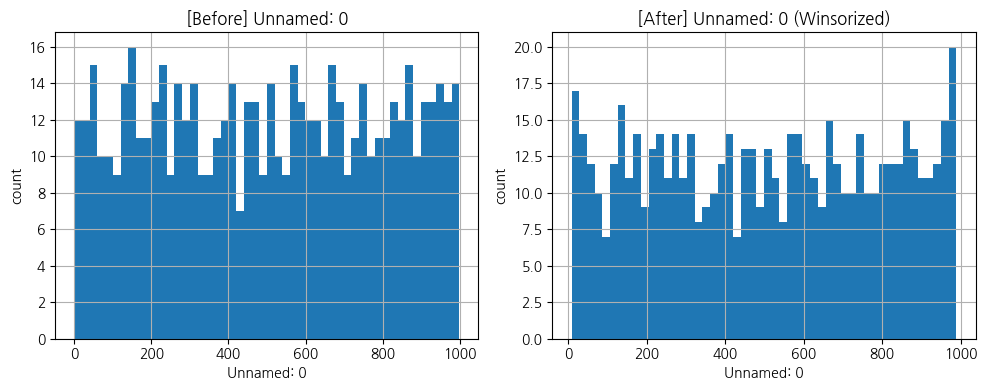

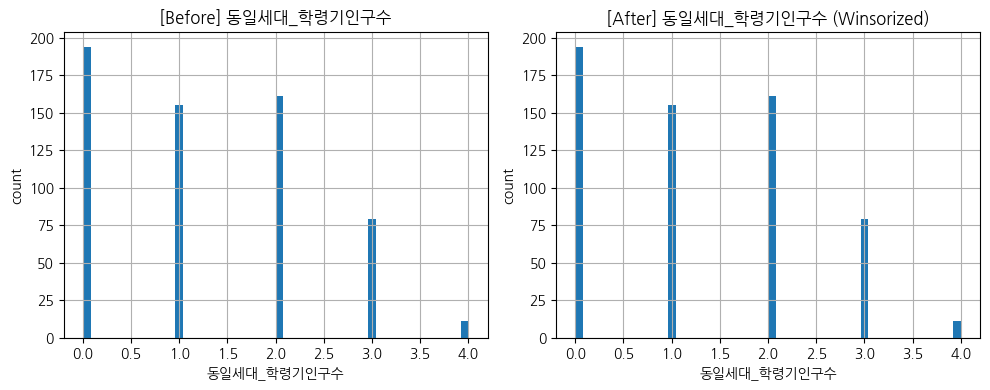

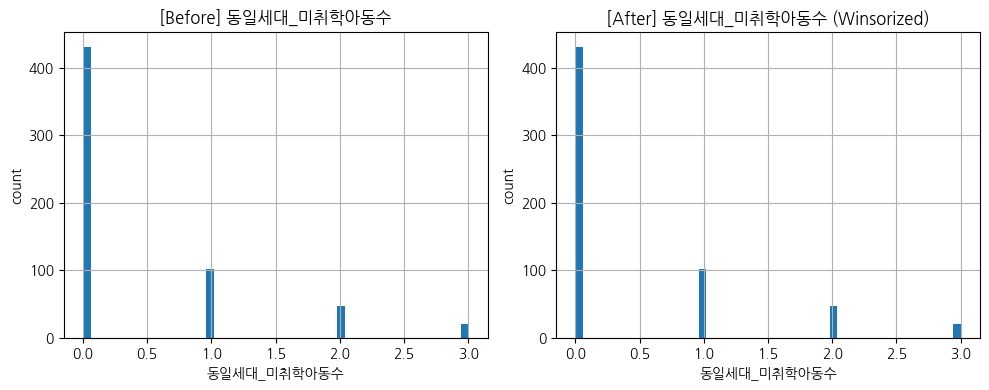

In [ ]:
import matplotlib.pyplot as plt  # 라이브러리

# 시각화 대상 컬럼 선택
plot_cols = numeric_cols[:3]  # 수치형 컬럼 전체 중 앞의 3개만 선택

# 컬럼별 반복 시각화
for col in plot_cols:
    plt.figure(figsize=(10, 4))  # Figure 생성 : 하나의 컬럼에 대해:가로로 긴 캔버스 생성,이후 2개의 subplot을 배치하기 위함
# Winsorizing 적용 전 분포
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째(왼쪽)
    X_train[col].hist(bins=50)  # 값을 50개 구간으로 나눠 빈도 표시
    plt.title(f"[Before] {col}")
    plt.xlabel(col)
    plt.ylabel("count")

 # Winsorizing 적용 후 분포
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    X_train_w[col].hist(bins=50)
    plt.title(f"[After] {col} (Winsorized)")
    plt.xlabel(col)
    plt.ylabel("count")

    plt.tight_layout()  # 레이아웃 정리 및 출력
    plt.show()


#### 왜 Winsorizing 전/후 분포가 크게 달라 보이지 않을까?

Winsorizing은 이상치를 “제거”하는 것이 아니라 상·하위 극단값만 살짝 제한(clipping) 하는 방식이다.

이번 실습에서는 상/하위 1%만 제한했기 때문에,
- 대부분의 데이터(약 98%)는 그대로 유지되고
- 변화는 꼬리(tail) 구간의 극단값 일부에서만 발생한다.

따라서 히스토그램처럼 전체 구간을 한 번에 보는 그래프에서는 전/후 차이가 크게 느껴지지 않을 수 있다.

하지만 Winsorizing의 효과는 다음에서 주로 나타난다.
- `max` 값이 과도하게 크던 변수가 안정화됨
- 평균/표준편차가 극단값에 덜 끌려감
- 특히 Logistic Regression 같은 선형 모델의 학습이 더 안정적으로 진행됨

즉, 분포를 “드라마틱하게 바꾸는 것”이 목적이 아니라 모델이 이상치에 과도하게 흔들리지 않도록 안전장치를 거는 것이 목적이다.


## 5. Feature Selection + Logistic Regression

전처리와 이상치 처리가 완료된 데이터를 바탕으로,이제 모델링 단계에 진입한다.

이 섹터에서는
- 모든 변수를 한꺼번에 사용하는 대신,
- 의미 있는 변수들을 선별(Feature Selection) 한 뒤
- 해석 가능한 모델(Logistic Regression) 을 통해 변수와 대출 여부의 관계를 살펴본다.

### 왜 Feature Selection이 필요한가?
현재 데이터에는
- 소비, 이동, 생활 패턴 등 다양한 변수가 포함되어 있으며,
- 일부 변수들은 정보가 중복되거나,
- 실제 예측에 거의 기여하지 않을 수도 있다.

Feature Selection은 모델의 복잡도를 낮추고, 해석 가능성을 높이며, 불필요한 노이즈를 줄이는 데 목적이 있다.

### 왜 Logistic Regression을 사용하는가?
Logistic Regression은
- 각 변수의 영향 방향(증가/감소)을 명확히 해석할 수 있고,
- 계수(coefficient)를 통해
  “어떤 요인이 대출 수용 가능성과 관련 있는지”를 설명할 수 있다.

따라서 이 섹터에서는
- LASSO 기반 Feature Selection
- Logistic Regression 모델
- 을 함께 사용하여 “의미를 설명할 수 있는 데이터” 를 만들어본다.


###  5-1. FS(피쳐 셀랙선) 을 위한 데이터 준비

- 범주형: Label Encoding
- 수치형: Standard Scaling

In [ ]:

from sklearn.preprocessing import LabelEncoder, StandardScaler

# 복사본 생성 (FS 전용)
X_train_fs = X_train_w.copy()
X_val_fs   = X_val_w.copy()

# 1) 범주형 컬럼 확인 : dtype이 object인 컬럼 → 범주형 변수 예:성별,직업군,지역 코드 등
# 👉 숫자형 모델(LASSO)은 문자열을 처리 못함
categorical_cols = X_train_fs.select_dtypes(include=["object"]).columns.tolist()
print("범주형 컬럼:", categorical_cols)

# 2) Label Encoding (train 기준)
# LabelEncoder() 생성,  각 컬럼마다 독립적인 인코더 사용
# fit_transform (Train) : Train 데이터 기준으로:범주 → 정수 매핑 학습,예: A → 0, B → 1, C → 2
# transform (Validation): 같은 매핑 규칙을 Validation에 적용, 새 기준을 만들지 않음 → Data Leakage 방지
# label_encoders 저장: 나중에:Test 데이터, 실서비스 데이터에 동일한 변환을 적용하기 위함


label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train_fs[col] = le.fit_transform(X_train_fs[col])
    X_val_fs[col]   = le.transform(X_val_fs[col])
    label_encoders[col] = le

# 3) 표준화 (LASSO는 스케일에 민감)
# LASSO는 스케일에 매우 민감
# StandardScaler의 의미: 각 컬럼을:평균 0, 표준편차 1 로 변환

scaler = StandardScaler()

X_train_fs_scaled = scaler.fit_transform(X_train_fs)
X_val_fs_scaled   = scaler.transform(X_val_fs)

# 처리 완료 확인
print("FS용 데이터 준비 완료")
print("X_train_fs_scaled shape:", X_train_fs_scaled.shape)


범주형 컬럼: ['자치구명', '성별', '세대주여부']
FS용 데이터 준비 완료
X_train_fs_scaled shape: (600, 114)


- LASSO 기반 Feature Selection을 수행하기 위해 Winsorizing된 데이터를 바탕으로
- 범주형 변수를 숫자로 변환하고,
- 모든 피처를 표준화하여
- FS에 바로 사용할 수 있는 데이터셋을 만드는 전처리 단계

- 목적 요약
- 이진 분류(대출여부)에 대해
- 불필요한 피처의 계수를 0으로 만들어 제거
- 모델 해석 가능 + 차원 축소

### 5-2. LASSO 기반 Feature Selection

In [ ]:

from sklearn.linear_model import LogisticRegression  # LogisticRegression: 이진 분류 + L1 규제(LASSO)
import pandas as pd
import numpy as np

# feature 이름 보존
# 스케일링 후 데이터(X_train_fs_scaled)는 numpy array → 컬럼명이 사라짐
# 원래 피처 이름을 따로 저장해 두어: 계수와 피처를 다시 매칭

feature_names = X_train_fs.columns

# LASSO Logistic Regression 모델 정의

lasso = LogisticRegression(
    penalty="l1",  # L1 규제 (LASSO)
    solver="liblinear",  # L1 규제를 지원하는 solver
    C=0.1,              # 규제 강도의 역수
    random_state=RANDOM_STATE
)

lasso.fit(X_train_fs_scaled, y_train)   # 표준화된 Train 데이터로만 학습

# 계수 확인
# lasso.coef_:shape: (1, n_features)[0]: 이진 분류의 단일 클래스 계수 벡터
# pd.Series로 변환: 피처명 ↔ 계수 매핑

coef = pd.Series(lasso.coef_[0], index=feature_names)

# 선택된 feature (계수 != 0)
# coef != 0 : LASSO가 살려둔 피처만 선택
# key=np.abs ; 계수의 절댓값 기준 정렬
# ascending=False : 영향력이 큰 피처부터 나열 👉 계수 절댓값이 클수록: 타깃(대출여부)에 미치는 영향이 큼

selected_features = coef[coef != 0].sort_values(key=np.abs, ascending=False)

# 결과 출력
# 최종적으로 선택된 피처 개수 확인
# 상위 20개 중요 피처를 미리 확인
print("선택된 feature 수:", len(selected_features))
display(selected_features.head(20))


선택된 feature 수: 37


,0
나이,-0.324533
신용카드기관수,0.244742
평일_이동_총횟수,0.209822
가맹점분류_이용비중6,0.185907
추정연소득_미추정여부,0.172881
차량보유,0.141174
12개월내_이용금액_비중11,0.116244
현금서비스이용금액_이용여부,0.100969
해외여행_이용금액,-0.083144
12개월내_이용금액_비중6,0.068445


### 5-3. LASSO 기반 Feature Selection 결과 해석

- 본 단계에서는 전처리가 완료된 데이터에 대해 LASSO Logistic Regression을 적용하여  
- 대출 여부 예측에 실질적으로 기여하는 변수들을 선별하였다.
- LASSO는 중요하지 않은 변수의 계수를 0으로 만들고, 해석 가능한 소수의 변수만 남긴다는 점에서  설명 중심 모델에 적합한 기법이다.

#### (1) 계수 해석 기준

- 모든 변수는 **표준화(Standard Scaling)** 된 상태에서 학습되었다.
- 따라서 계수는 다음과 같이 해석한다.

- **절댓값(|coef|)**  
  → 대출 여부에 미치는 영향력의 크기  
- **부호(+, −)**  
  → 해당 변수가 증가할 때 대출 확률이 증가/감소하는 방향

즉,
> “다른 조건이 같을 때,  
> 이 변수가 커지면 대출 확률이 어떻게 변하는가?”  
를 의미한다.

---

### (2) 영향력이 큰 핵심 변수 해석

#### ▪ 나이 (−)

- 나이가 증가할수록 대출 확률은 감소하는 경향을 보인다.
- 젊은 연령대일수록
  - 금융 상품에 대한 접근성이 높고
  - 신규 대출 수요가 크다는 현실과 부합한다.

**분석 포인트**
- 나이는 단순 인구통계 변수가 아니라  
  **금융 행동과 위험 선호도를 반영하는 핵심 설명 변수**다.

---

#### ▪ 신용카드기관수 (+)

- 거래 중인 카드사 수가 많을수록 대출 확률이 증가한다.
- 이는 금융 활동 범위가 넓고,
  금융 시스템에 충분히 노출된 고객일 가능성을 의미한다.

**분석 포인트**
- 대출 여부는 소득보다  
  **금융 접점의 다양성**과 더 밀접하게 연결될 수 있다.

---

#### ▪ 가맹점분류_이용비중6 (+)

- 해당 컬럼은 의류/잡화_이용비중이다.
- 의류/잡화 소비 비중이 높을수록 대출 확률은 증가하는 경향을 보인다.
- 특히 의류/잡화는 필수재가 아닌 선택재 성격을 가지므로,
소비 비중이 높다는 것은 소득 대비 지출 성향이 강하다는 의미로 해석될 수 있다.


**분석 포인트**
- 단순한 소비 패턴이 아니라,
**소비 성향과 대출 수요 간의 연결고리**를 보여주는 변수다.
- 이는 소득 수준과 무관하게,
지출 구조와 금융 행동이 대출 여부를 설명하는 중요한 단서가 될 수 있음을 보여준다.

---

#### ▪ 평일_이동_총횟수 (+)

- 평일 이동이 활발할수록 대출 확률이 높아진다.
- 이동 데이터는
  - 직장 활동
  - 경제 활동성
을 간접적으로 반영하는 **행동 기반 프록시 변수**다.

**분석 포인트**
- 비금융 데이터(이동, 행동)도  
  금융 의사결정을 설명하는 데 충분히 유의미하다.

---

### (3) 소득 전처리 전략 검증

#### ▪ 추정연소득_미추정여부 (+)

이 변수는 매우 중요한 해석 포인트다.

- 이는 **소득이 낮다는 의미가 아니다**
- **소득 추정 자체가 불안정하거나 어려운 상태**를 의미한다.

포함될 수 있는 경우:
- 자영업자, 프리랜서
- 금융 이력이 부족한 고객
- 소비·이동 패턴이 충분하지 않은 경우

**분석 포인트**
- “얼마를 버는가”보다  
  **“소득 정보가 얼마나 명확한가”** 가  
  대출 행동과 더 강하게 연결될 수 있다.
- 소득을 플래그와 값으로 분리한 전처리 전략이 유효했음을 보여준다.

---

#### ▪ log_추정연소득 (+)

- 소득 규모 자체도 여전히 의미는 있으나,
- 영향력은 상대적으로 제한적이다.

**분석 포인트**
- 대출 여부는  
  단순 소득 크기보다  
  **소득의 안정성 + 행동 패턴**과 함께 해석되어야 한다.

---

### (4) 소비/행동 기반 변수의 의미

#### ▪ 현금서비스이용금액_이용여부 (+)

- 현금서비스를 이용한 경험 자체가
  대출 가능성과 양의 관계를 가진다.

#### ▪ 마케팅_온라인쇼핑_이용금액_이용여부 (−)

- 온라인 쇼핑 소비가 존재하는 경우,
  상대적으로 대출 확률이 낮아지는 경향을 보인다.

**분석 포인트**
- Zero-Inflated 분포 변수에서는  
  금액 크기보다 **행동의 존재 여부(flag)** 가  
  중요한 설명력이 될 수 있다.

---

### (5) 기타 변수 해석

- `자치구명`  
  → 지역별 생활·소비 패턴 차이가 대출 행동에 반영됨  
- `차량보유`, `사업자여부`  
  → 생활 안정성·경제 활동 상태를 간접적으로 설명  
- 가맹점 분류 이용 비중 계열  
  → 소비 구조의 차이가 대출 수요와 연결됨

---

### (6) 핵심 정리

이번 LASSO 결과는 다음과 같은 메시지를 전달한다.

> **대출 여부는  
> 단순히 ‘소득이 높은가’의 문제가 아니라,  
> ‘얼마나 활발히 활동하고,  
> 금융 시스템에 얼마나 노출되어 있으며,  
> 그 정보가 얼마나 명확한가’의 문제다.**



---
---
---


### 5-4. Logistic Regression 모델 학습 및 해석

앞선 LASSO 기반 Feature Selection을 통해 대출 여부 예측에 의미 있는 변수들을 선별하였다.

이제 선택된 변수들만을 사용하여  Logistic Regression 모델을 학습하고,  
각 변수들이 대출 여부에 어떤 영향을 미치는지 해석한다.

이 단계의 목적은
- 최고 성능의 모델을 만드는 것이 아니라
- “왜 이 고객이 대출을 받을 가능성이 높은가”를 설명하는 것이다.

---
#### (1) Logistic Regression을 사용하는 이유

Logistic Regression은
- 변수의 영향 방향(증가 / 감소)을 명확히 해석할 수 있고
- 각 변수의 계수를 통해
  대출 여부와의 관계를 직관적으로 설명할 수 있다.

따라서 본 프로젝트에서는
- Logistic Regression을 **해석 중심의 기준 모델(baseline)** 로 사용한다.

---
#### (2) 학습 데이터 구성

- 입력 변수:  
  LASSO를 통해 선택된 변수들만 사용
- 타깃 변수:  
  `대출여부`
- 학습 데이터(train)를 기준으로 모델을 학습하고,
- 검증 데이터(validation)를 통해 성능을 평가한다.

---

#### (3) 성능 평가 기준

본 프로젝트에서는
- Recall(재현율)을 핵심 지표로 사용한다.

이는 대출 마케팅 관점에서
- “대출을 받을 가능성이 있는 고객을 놓치지 않는 것”이
- “잘못 추천하는 것”보다 더 중요하기 때문이다.

Confusion Matrix를 함께 확인하여,
- 어떤 유형의 오분류가 발생하는지도 함께 살펴본다.


- LASSO로 선택된 feature만 사용--> 해석 목적의 Logistic Regression을 학습 --> Validation 데이터에서 분류 성능을 평가하는 단계

In [ ]:
# =========================
# 5-4. Logistic Regression (LASSO-selected features)
# =========================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# LASSO로 선택된 feature 이름
final_features = selected_features.index.tolist()
final_idx = [list(X_train_fs.columns).index(c) for c in final_features]  # final_idx:LASSO에서 선택된 feature의 인덱스

# Train / Validation 데이터에서 동일 feature만 선택
X_train_logit = X_train_fs_scaled[:, final_idx]
X_val_logit   = X_val_fs_scaled[:, final_idx]

# Logistic Regression (해석 목적 → 규제 없음)
# 규제 없는 이유는 이미 LASSO에서:불필요한 변수 제거 완료
# 여기서는: 계수 크기/부호 해석이 목적

logit = LogisticRegression(
    penalty=None,
    max_iter=1000,
    random_state=RANDOM_STATE
)

# 모델 학습
logit.fit(X_train_logit, y_train)  # Train 데이터만 사용: Validation/Test 정보는 사용

# Validation 데이터 예측
y_val_pred = logit.predict(X_val_logit)  # 클래스 예측 (0 / 1),기본 threshold = 0.5

# 평가 : 혼동 행렬 (Confusion Matrix)
cm = confusion_matrix(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print("Confusion Matrix")
print(cm)
print()
print(f"Precision: {precision:.3f}")  # 소수점 3자리까지 출력
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}")


Confusion Matrix
[[55 39]
 [31 75]]

Precision: 0.658
Recall   : 0.708
F1-score : 0.682


## 6. Tree 기반 모델 (RandomForest, XGBoost)

- 앞선 Logistic Regression은 변수의 의미와 방향성을 설명하는 데 초점을 둔 모델이었다.
- 이번 섹터에서는 성능 중심 모델인 Tree 기반 알고리즘을 사용하여 동일한 데이터에서 예측 성능이 어떻게 달라지는지 확인한다.
- Tree 기반 모델(RandomForest, XGBoost) :변수 간 비선형 관계를 자동으로 학습하고, 변수 스케일에 민감하지 않으며, Feature Selection 없이도 중요한 변수를 내부적으로 선택한다.

- 따라서 이 단계에서는 별도의 Feature Selection 없이, 전처리 완료된 전체 feature를 그대로 사용한다.

### 6-1. 범주형 변수 Label Encoding (Tree 모델용)

- 이상치(Winsorizing)까지 처리된 데이터를 기준으로
- 범주형 변수를 숫자로 변환(Label Encoding)하여
- 모델 학습에 바로 사용할 수 있게 만드는 전처리 단계

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 이상치 처리까지 끝난 데이터 기준, 인코딩용 데이터 복사
# Winsorizing까지 완료된 데이터를 복사,원본(_w)을 보존하면서: 인코딩 전용 버전(_enc) 생성
X_train_enc = X_train_w.copy()
X_val_enc   = X_val_w.copy()
X_test_enc  = X_test_w.copy()
# LabelEncoder 저장용 딕셔너리
label_encoders = {}

#범주형 컬럼 반복 처리,  ( le: Label Encoding)
for col in categorical_cols:
    le = LabelEncoder()   # 각 컬럼마다 독립적인 인코더, 컬럼 간 범주 혼합 방지

    # Train 기준 인코딩  ( le: Label Encoding)
    X_train_enc[col] = le.fit_transform(X_train_enc[col])  #Train 데이터로:범주 목록 학습(fit), 숫자로 변환(transform)

    # Validation / Test 인코딩 ( le: Label Encoding)
    X_val_enc[col]  = le.transform(X_val_enc[col])  # Train에서 만든 동일한 매핑 규칙 적용
    X_test_enc[col] = le.transform(X_test_enc[col])

    label_encoders[col] = le  # 인코더 저장, 컬럼명 → LabelEncoder 객체 매핑
# 처리 완료 확인
print("Label Encoding 완료 컬럼:", categorical_cols)
print("X_train_enc shape:", X_train_enc.shape)  # shape로:컬럼 누락, 행 손실, 이 없는지 점검

Label Encoding 완료 컬럼: ['자치구명', '성별', '세대주여부']
X_train_enc shape: (600, 114)


### 6-2. RandomForest 모델 정의

- 랜덤 포레스트(Random Forest) 분류 모델을 생성(초기화)하는 단계
- 아직 학습(fit)은 하지 않았고, 모델의 구조와 하이퍼파라미터만 설정한 상태

In [ ]:
# RandomForestClassifier:여러 개의 결정트리(Decision Tree)를 앙상블로 묶은, 비선형·강건한 분류 모델
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,  # n_estimators=300: 생성할 결정트리 개수, 값이 클수록:성능 안정성 ↑,학습/예측 시간 ↑,300은 실무에서 자주 쓰는 충분히 큰 값
    max_depth=None,  # 각 트리의 최대 깊이 제한 없음 트리가:데이터가 허용하는 한 끝까지 분기, 대신 아래 min_samples_leaf로 과적합 제어
    min_samples_leaf=5,  # 리프 노드 하나에 들어가야 하는 최소 샘플 수,  효과: 실무에서 과적합 방어용 핵심 파라미터
    random_state=RANDOM_STATE,  # 난수 고정,모델 결과 재현 가능
    n_jobs=-1  # n_jobs = number of jobs; 사용 가능한 모든 CPU 코어 사용, 학습 속도 대폭 개선,  “내 컴퓨터에서 쓸 수 있는 CPU 코어를 전부 써라”
)

print("RandomForest model initialized")


RandomForest model initialized


In [ ]:
# n_jobs = number of jobs 동시에 실행할 작업(프로세스) 개수
# n_jobs = 1 : 단일 코어 사용 (기본)
# n_jobs = 4 : CPU 4개 코어 사용
# n_jobs = -1 : n_jobs = -1

### 6-3. XGBoost 모델 정의

- XGBoost 분류 모델을 초기화(설정)하는 단계
- 아직 학습은 하지 않았고, 모델의 구조와 하이퍼파라미터만 정의한 상태

In [ ]:
# XGBClassifier: Gradient Boosting 기반의 고성능 트리 앙상블 모델

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,  #생성할 트리 개수
    max_depth=5,   # 각 트리의 최대 깊이
    learning_rate=0.05,  # 각 트리가 전체 모델에 기여하는 비율,작을수록:학습은 느리지만, 일반화 성능 ↑
    subsample=0.8,  # 각 트리가 전체 모델에 기여하는 비율,  작을수록:학습은 느리지만. 일반화 성능 ↑
    colsample_bytree=0.8,  # 각 트리에서 사용할 피처 비율
    objective="binary:logistic",   # 이진 분류 목적 함수, 출력:클래스 확률 (0~1)
    eval_metric="logloss",  # 학습 중 성능 평가 지표
    random_state=RANDOM_STATE,  # 난수 고정, 실험 재현성 확보
    n_jobs=-1   # 사용 가능한 모든 CPU 코어 사용
)

print("XGBoost model initialized")  # 모델 초기화 확인 ,  모델 객체가 정상적으로 생성되었음을 알림


XGBoost model initialized


### 6-4 모델 학습

- 전처리가 완료된 학습 데이터로 RandomForest와 XGBoost 두 모델을 실제로 학습시키는 단계

In [ ]:
# RandomForest
rf.fit(X_train_enc, y_train) # X_train_enc:이상치 처리 + 범주형 인코딩이 끝난 피처 데이터, y_train: 타깃(대출여부, 0/1)
## 내부에서 일어나는 일
## 300개의 결정트리를: 서로 다른 샘플/피처 조합으로 학습
## 각 트리는: 독립적으로 학습됨
##  최종 예측은: 트리들의 다수결(또는 평균 확률)

# XGBoost
xgb.fit(X_train_enc, y_train)

# 두 모델이 정상적으로 학습되었음을 확인: 이 시점 이후에는: predict(), predict_proba() 로 성능 평가 가능
print("RF & XGB training completed")


RF & XGB training completed


### 6-5. 모델 성능 평가 (Validation)

- 여러 분류 모델의 성능을 동일한 기준으로 평가·비교하기 위한
- 공용 평가 함수(evaluation function)를 정의하고,
- Validation 데이터에서 RandomForest와 XGBoost의 성능을 비교하는 단계

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# 모델 평가 함수 정의
def evaluate_model(model, X, y, model_name="model"):
    y_pred = model.predict(X)   # 예측 수행, 입력 데이터 X에 대해:클래스 예측값(0/1) 생성, 기본 threshold = 0.5
    cm = confusion_matrix(y, y_pred)    # 혼동 행렬 계산 : 실제값(y) vs 예측값(y_pred) 비교
    precision = precision_score(y, y_pred)  # Precision:→ “대출이라고 예측한 것 중 실제 대출 비율”
    recall = recall_score(y, y_pred)  # Recall:→ “실제 대출 중 맞춘 비율”
    f1 = f1_score(y, y_pred)   # Precision과 Recall의 조화 평균

    print(f"\n[{model_name}]")
    print("Confusion Matrix")
    print(cm)
    print(f"Precision: {precision:.3f}")  # 소수점 3자리로 통일 → 비교 용이
    print(f"Recall   : {recall:.3f}")
    print(f"F1-score : {f1:.3f}")

# Validation 성능 비교
evaluate_model(rf, X_val_enc, y_val, "RandomForest")
evaluate_model(xgb, X_val_enc, y_val, "XGBoost")



[RandomForest]
Confusion Matrix
[[54 40]
 [20 86]]
Precision: 0.683
Recall   : 0.811
F1-score : 0.741

[XGBoost]
Confusion Matrix
[[59 35]
 [24 82]]
Precision: 0.701
Recall   : 0.774
F1-score : 0.735


### 6-6  RandomForest 분기 구조 시각화 (해석 보조)

- RandomForest는 여러 개의 Decision Tree를 앙상블한 모델이다.
- 전체 모델을 하나의 규칙으로 해석하는 것은 어렵지만,
- 개별 트리 하나를 시각화하면 모델이 어떤 기준으로 분기를 시도하는지 감을 잡을 수 있다.

- 왜 트리 하나만 보는가?
- RandomForest는 수십~수백 개의 트리를 사용
- 전체 구조를 시각화하면 해석 불가능하다.
- 대신,대표적인 한 개의 트리 혹은 상위 분기 규칙을 통해 의사결정 방향을 이해한다
- 이 시각화는 “모델을 완전히 설명하기 위함”이 아니라 모델이 어떤 변수들을 기준으로 판단하려 하는지 감각을 얻기 위한 목적이다.

- 학습이 끝난 RandomForest 모델 내부에 있는 결정트리 하나를 꺼내서 구조를 시각화하는 교육·해석용 코드

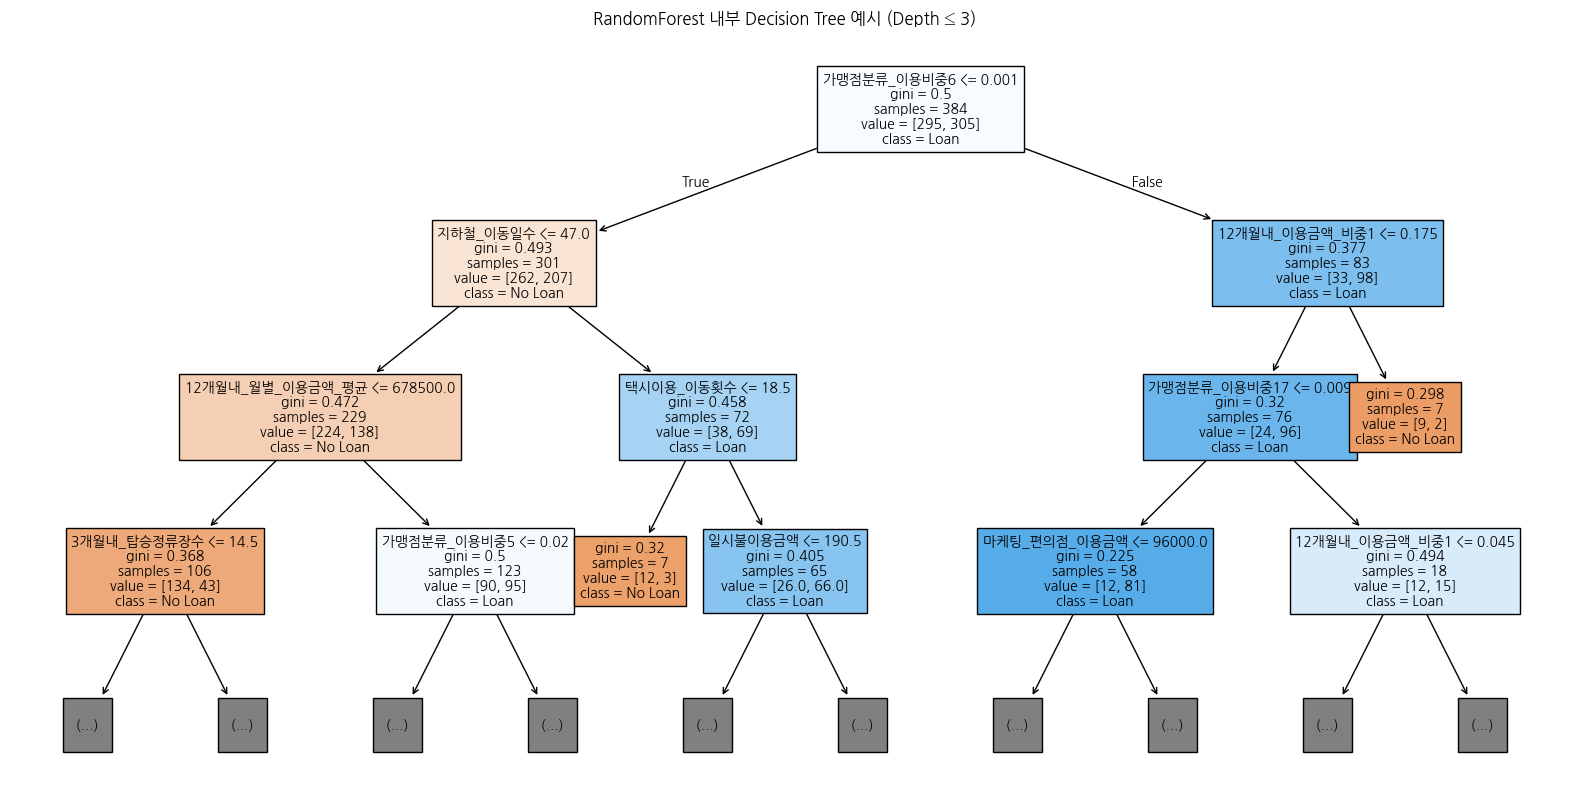

In [ ]:
from sklearn.tree import plot_tree

# RandomForest에서 첫 번째 트리 선택
tree_estimator = rf.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(
    tree_estimator,
    feature_names=X_train.columns,
    class_names=["No Loan", "Loan"],
    filled=True,
    max_depth=3,      # 교육용: 깊이 제한
    fontsize=10
)
plt.title("RandomForest 내부 Decision Tree 예시 (Depth ≤ 3)")
plt.show()


### 6.7 XGBoost  설명가능한 AI : SHAP = SHapley Additive exPlanations

- XGBoost는 Gradient Boosting 기반의 앙상블 모델이다.
- 개별 트리의 분기 구조를 직접 해석하기보다는,SHAP(Shapley Additive Explanations) 값을 활용해 모델이 어떤 변수에 얼마나 강하게 의존하는지를 시각적으로 확인할 수 있다.
- SHAP(Shapley Additive exPlanations) : 게임이론의 Shapley value를 기반으로, 각 피처가 모델 예측에 얼마나 기여했는지를 수치로 설명하는 기법
- 왜 SHAP을 보는가?
- XGBoost는 수십~수백 개의 트리를 순차적으로 학습
- 전체 트리 구조를 직접 해석하는 것은 사실상 불가능
- 대신, SHAP은 게임이론 기반 기여도 분석을 통해 각 변수의 예측 기여도를 직관적으로 보여준다.
- 즉, SHAP 시각화는 변수별 중요도와 방향성을 확인, 특정 고객/관측치에 대해 어떤 변수가 대출 여부 예측을 증가(+) 또는 감소(−) 시켰는지 파악

- 학습된 XGBoost 모델이 각 피처를 어떻게 사용해 예측했는지 설명하기 위해 SHAP 값을 계산하는 단계

In [ ]:
import shap    # SHAP (Shapley Additive exPlanations) 라이브러리

# Tree 기반 모델용 Explainer
explainer = shap.TreeExplainer(xgb)   # TreeExplainer:트리 기반 모델 전용 SHAP 계산기, XGBoost, RandomForest, LightGBM에 최적화
shap_values = explainer.shap_values(X_train_enc) # SHAP 값 계산, X_train_enc:이상치 처리 + 범주형 인코딩이 끝난 학습 데이터, 각 샘플 × 각 피처에 대해:


- SHAP 값으로부터 “전체적으로 어떤 피처가 중요한가”를 한눈에 보여주는 전역(Global) 중요도 시각화

/tmp/ipython-input-717029716.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


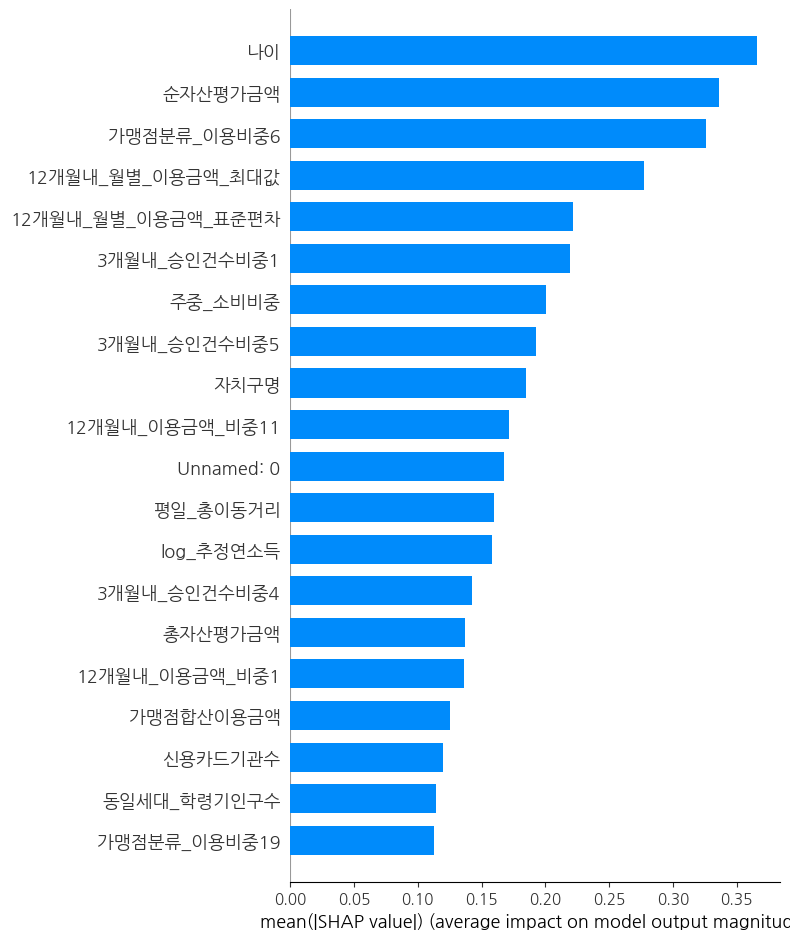

In [ ]:
# shap.summary_plot :  SHAP에서 가장 많이 쓰이는 요약 시각화 함수
# shap_values:  앞에서 계산한 SHAP 값 , 형태: (샘플 수, 피처 수)
# 각 값은: 해당 피처가 예측에 얼마나 기여했는지를 의미
# X_train_enc:  SHAP 값을 계산한 입력 데이터 , 피처 이름을 그래프에 표시하는 데 사용
# plot_type="bar":  막대 그래프 형태로 출력,  각 피처의: mean(|SHAP value|) → 평균 절댓값 기여도 , 즉, 방향성(+/−)은 무시하고 “중요도 크기”만 표시

shap.summary_plot(
    shap_values,
    X_train_enc,
    plot_type="bar"
)


- 막대가 길수록: 모델 예측에 전반적으로 큰 영향

- 언제 이 그래프를 쓰나?
- 1) 전체 모델 해석
- “이 모델은 어떤 변수에 가장 의존하나?”
- 2) 모델 비교
- RF vs XGB
- 튜닝 전/후 중요도 변화
- 3) 리포트/보고서
- 비전문가에게도 설명 쉬움

- SHAP에서 가장 대표적인 요약 시각화(summary plot, 기본형)
- 피처 중요도 + 영향 방향 + 값의 분포를 한 번에 보여준다.

- “어떤 피처가 중요한지 + 그 피처 값이 예측을 어떻게 바꾸는지”
- 즉, 전역 중요도(Global importance)
- 방향성(증가 / 감소)
- 데이터 분포(Local variation)를 동시에 표현한다.

In [ ]:
# shap_values : 각 샘플 × 각 피처의 SHAP 값
# 의미: (+) → 대출 확률을 올리는 방향 , (-)→ 대출 확률을 내리는 방향

# X_train_enc : SHAP 값을 계산한 입력 데이터
# 각 점의 색깔(피처 값 크기)을 표현하는 데 사용
# 빨강 → 값이 큼
# 파랑 → 값이 작음

shap.summary_plot(
    shap_values,
    X_train_enc
)


NameError: name 'shap' is not defined

- 그래프 읽는 법 (아주 중요)
- y축: 피처 목록 : 위에 있을수록 중요
- 중요도 기준:  mean(|SHAP value|)가 큰 순서
- x축: SHAP 값
- 오른쪽(+) → 대출 가능성 증가
- 왼쪽(−) → 대출 가능성 감소
-  점 하나 = 샘플 하나
- 같은 피처라도:샘플마다 영향이 다를 수 있음
- 색깔 = 피처 값 크기
- 🔴 빨강: 피처 값 큼
- 🔵 파랑: 피처 값 작음
- 예시 해석: 빨간 점이 오른쪽에 많다 → 값이 클수록 대출 가능성 ↑
- 빨간 점이 왼쪽에 많다. → 값이 클수록 대출 가능성 ↓

## 7. Neural Network 모델 개발

트리 기반 모델(RandomForest, XGBoost)은 비선형 패턴을 잘 포착하고 성능이 우수했다.

이번 섹터에서는 비교 관점에서
- 신경망(Neural Network) 모델을 추가로 학습하여,
- 동일 데이터에서 NN이 얼마나 성능을 낼 수 있는지 확인한다.

주의할 점:
- NN은 입력 스케일에 민감하므로, StandardScaler로 스케일링을 적용한다.
- 성능은 트리 모델보다 떨어질 수도 있으며,
  본 섹터는 “성능 경쟁”보다 “모델 패러다임 비교”에 목적이 있다.


### 7-1. NN 입력 데이터 준비 (Scaling)

- 신경망(Neural Network) 모델 학습을 위해 입력 데이터와 타깃 데이터를 NN 친화적인 형태로 변환하는 전처리 단계

- 신경망 모델 학습을 위해
- 범주형 인코딩과 이상치 처리가 끝난 데이터를
- Train 기준으로 표준화하고,
- 입력은 float32, 타깃은 int32로 변환하여
- NN에 바로 투입할 수 있는 형태로 만드는 전처리 단계

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler_nn = StandardScaler()  # StandardScaler 생성

# 입력 데이터 표준화 + 자료형 변환
# Train 기준 스케일링:   fit_transform → Train ,  transform → Val / Test 데이터 누수(Data Leakage) 방지
# astype(np.float32) : 딥러닝 프레임워크(TensorFlow / PyTorch)의 기본 dtype, 메모리 절약 + 연산 속도 개선

X_train_nn = scaler_nn.fit_transform(X_train_enc).astype(np.float32)
X_val_nn   = scaler_nn.transform(X_val_enc).astype(np.float32)
X_test_nn  = scaler_nn.transform(X_test_enc).astype(np.float32)

# 타깃(y) 데이터 정리
# 타깃을:int32 형태의 numpy 배열로 통일
# 이유:PyTorch / TensorFlow에서 classification loss가 정수형 라벨을 요구하는 경우 많음
# hasattr(y, "values") : y가 pandas Series → .values 존재, numpy array → .values 없음, 어떤 경우에도 안전하게 numpy array로 변환

y_train_nn = y_train.values.astype(np.int32) if hasattr(y_train, "values") else np.array(y_train, dtype=np.int32)
y_val_nn   = y_val.values.astype(np.int32)   if hasattr(y_val, "values")   else np.array(y_val, dtype=np.int32)
y_test_nn  = y_test.values.astype(np.int32)  if hasattr(y_test, "values")  else np.array(y_test, dtype=np.int32)

# shape 확인
print("X_train_nn:", X_train_nn.shape, "y_train:", y_train_nn.shape)
print("X_val_nn  :", X_val_nn.shape, "y_val  :", y_val_nn.shape)
print("X_test_nn :", X_test_nn.shape, "y_test :", y_test_nn.shape)


X_train_nn: (600, 114) y_train: (600,)
X_val_nn  : (200, 114) y_val  : (200,)
X_test_nn : (200, 114) y_test : (200,)


### 7-2. NN 모델 정의

- 기본적인 신경망(Neural Network, MLP) 모델을 정의하고 컴파일하는 단계

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(RANDOM_STATE)  # 랜덤 시드 고정
# 입력 피처 개수 설정: 학습 데이터의:컬럼(피처) 개수, 신경망 입력층 크기 결정

n_features = X_train_nn.shape[1]
# 신경망 모델 정의
# Input(shape=(n_features,)) : 입력 벡터 크기 = 피처 개수,  한 샘플은 (n_features,) 형태
# Dense(32, activation="relu") : 은닉층 (Hidden Layer), 뉴런 32개, ReLU: 비선형성 부여
# Dense(1, activation="sigmoid"): 출력층, 이진 분류이므로 뉴런 1개, sigmoid: 출력값 ∈ (0, 1), “대출일 확률”로 해석 가능


model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# 모델 컴파일
# Optimizer: Adam,  가장 널리 쓰이는 최적화 알고리즘
# learning_rate=1e-3:기본적이고 안정적인 값
# Loss: binary_crossentropy:  이진 분류의 표준 손실 함수
# Metrics : AUC (ROC-AUC): 클래스 불균형에 강함
# PR-AUC:  양성(대출=1) 클래스가 중요한 경우 유용


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.AUC(curve="PR", name="pr_auc")
    ]
)

model.summary()  # 모델 구조 요약 출력


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         3,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

### 7-3. NN 학습

- 클래스 불균형을 보정하면서 신경망 모델을 안정적으로 학습시키는 단계
- 핵심은 1) class weight 적용 + 2) Early Stopping

- 대출여부(0/1) 불균형 문제 대응
- 과적합 방지
- 가장 성능이 좋은 시점의 모델을 자동으로 선택

### history 객체란?
- epoch별로:
- loss
- auc
- pr_auc
- val_loss
- val_pr_auc 등이 저장됨 👉 이후 학습 곡선 시각화 가능

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

# compute_class_weight : 클래스 불균형 보정용 가중치 계산
# EarlyStopping ; 검증 성능이 더 이상 좋아지지 않으면 학습 중단

# y_train_nn의 실제 분포를 보고: 적은 클래스(대출=1)에 더 큰 가중치, 많은 클래스(대출=0)에 더 작은 가중치

classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_nn
)

# Keras model.fit()에서 요구하는 형식:{클래스값: 가중치}
# 학습 시: 대출=1 샘플의 손실(loss)을 더 크게 반영
class_weight = {0: class_weights[0], 1: class_weights[1]}  # Keras용 class_weight 딕셔너리 생성
print("class_weight:", class_weight)

# EarlyStopping 콜백 설정
early_stop = EarlyStopping(
    monitor="val_pr_auc",   # 검증 데이터의 PR-AUC 기준으로 성능 감시, 불균형 문제에 적합
    mode="max",  # 값이 클수록 좋은 지표이므로 max
    patience=8,             # 8 epoch 동안 성능 개선이 없으면 학습 중단, 과적합 방지, 5~10 사이 추천
    restore_best_weights=True,  # 학습 종료 후:가장 성능 좋았던 시점의 가중치로 복원
    verbose=1
)
# 모델 학습
history = model.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=100,  # epochs=100 최대 학습 횟수
    batch_size=32,  # 한 번에 처리할 샘플 수
    class_weight=class_weight,  # 클래스 불균형 보정 적용: 소수 클래스(대출=1) 학습 강화
    callbacks = [early_stop],   # 과적합 방지 + 최적 모델 자동 선택
    verbose=1
)


class_weight: {0: np.float64(1.0638297872340425), 1: np.float64(0.9433962264150944)}
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - auc: 0.5156 - loss: 0.9406 - pr_auc: 0.5636 - val_auc: 0.6396 - val_loss: 0.8184 - val_pr_auc: 0.7003
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.6617 - loss: 0.7322 - pr_auc: 0.6775 - val_auc: 0.6872 - val_loss: 0.7088 - val_pr_auc: 0.7195
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.7128 - loss: 0.6448 - pr_auc: 0.7221 - val_auc: 0.6997 - val_loss: 0.6673 - val_pr_auc: 0.7267
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.7445 - loss: 0.6032 - pr_auc: 0.7574 - val_auc: 0.7039 - val_loss: 0.6502 - val_pr_auc: 0.7328
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.7711 - loss: 0.5769 - pr_auc: 0.7872 - val_auc: 0.7087 - val_loss: 0.6413 - val_pr_auc: 0.7412
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.7923 - loss: 0.5554 - pr_auc: 0.8100 - val_auc: 0.7118 - val_loss: 0.6365 - va

### 7-4. NN 성능 평가 (threshold=0.5)

- 학습이 끝난 신경망 모델을 Validation / Test 데이터에서 평가하는 단계

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, average_precision_score

# 확률 예측
# 신경망 출력은:sigmoid → 확률(0~1)
# .ravel():shape (N, 1) → (N,) 1차원 벡터로 변환,  sklearn metric 함수 호환

val_proba = model.predict(X_val_nn).ravel()
test_proba = model.predict(X_test_nn).ravel()

# 기본 threshold
# 확률 ≥ 0.5 → 대출(1),  확률 < 0.5 → 미대출(0)
# 기본 threshold(0.5)를 사용한 baseline 평가 👉 이후 threshold 튜닝 가능

thr = 0.5
val_pred = (val_proba >= thr).astype(int)
test_pred = (test_proba >= thr).astype(int)

# 평가 함수 정의
def print_metrics(y_true, y_pred, y_proba, name="set"):  # 혼동행렬 + Precision / Recall / F1 / PR-AUC를 한 번에 출력
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_proba)  # PR-AUC 계산:의미 Precision-Recall Curve 아래 면적
# 결과 출력
    print(f"\n[{name}] threshold={thr}")
    print("Confusion Matrix")
    print(cm)
    print(f"Precision: {precision:.3f}")
    print(f"Recall   : {recall:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"PR-AUC   : {pr_auc:.3f}")
# Validation / Test 평가 실행
print_metrics(y_val_nn, val_pred, val_proba, "Validation")
print_metrics(y_test_nn, test_pred, test_proba, "Test")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

[Validation] threshold=0.5
Confusion Matrix
[[64 30]
 [39 67]]
Precision: 0.691
Recall   : 0.632
F1-score : 0.660
PR-AUC   : 0.764

[Test] threshold=0.5
Confusion Matrix
[[62 32]
 [46 60]]
Precision: 0.652
Recall   : 0.566
F1-score : 0.606
PR-AUC   : 0.653


- Validation 데이터에서 분류 임계값(threshold)을 바꿔가며 Recall을 최우선으로 하는 최적 threshold를 찾는 과정

In [ ]:
# =========================
# Validation에서 Recall 우선 Threshold 탐색
# =========================
# 초기값 설정
best_thr = None  # 가장 좋은 threshold(임계값)를 저장할 변수, 아직 어떤 threshold가 좋은지 모르므로 → None으로 시작
best_recall = -1  # 지금까지 관측한 Recall 중 최고값을 저장하는 변수,  0 ≤ Recall ≤ 1, -1로 시작하 무조건 -1보다 커서 따라서 첫 반복에서 반드시 갱신됨
best_precision = None # 최적 threshold에서의 Precision 값을 저장, Recall을 기준으로 Precision은 “참고용 결과” 아직 계산 전 → None

# threshold 후보 범위 설정
for t in np.arange(0.1, 0.91, 0.05):
    pred = (val_proba >= t).astype(int)  # threshold별 예측값 생성
    r = recall_score(y_val_nn, pred)   # Recall / Precision 계산
    p = precision_score(y_val_nn, pred)
    if r > best_recall:   # Recall 기준으로 최적 threshold 선택
        best_recall = r
        best_thr = t
        best_precision = p

print("Best threshold (Recall 우선):", best_thr)
print("Recall:", round(best_recall, 3), "Precision:", round(best_precision, 3))


Best threshold (Recall 우선): 0.1
Recall: 0.972 Precision: 0.531


## 8. 프로젝트 최종 결론: 대출 수용 가능 고객의 행동 패턴

- 본 프로젝트에서는 서울시민의 소비·이동·생활 패턴 데이터를 기반으로  
- “대출을 수용할 가능성이 높은 고객의 공통 행동 특성”을 도출하고자 했다.
- 단순히 예측 성능이 높은 모델을 만드는 것이 아니라,
- 모델이 무엇을 근거로 판단하는지 설명 가능한 형태로 이해하는 것을 핵심 목표로 삼았다.

#### 1. 최종 모델 선정 결과

여러 모델을 비교한 결과:

- Logistic Regression (LASSO 기반)
- RandomForest
- XGBoost
- Neural Network

중에서,  
**XGBoost 모델이 성능(Recall)과 해석 가능성의 균형이 가장 우수**하였다.

- Recall 기준 성능이 가장 안정적으로 높았으며
- SHAP 분석을 통해 주요 변수와 방향성을 명확히 해석할 수 있었다.

Neural Network 역시 유사한 Recall 성능을 달성할 수 있었으나,
- 데이터 규모가 제한적이고
- 고객 행동 기반의 tabular 데이터 특성상
- 모델 안정성과 해석 측면에서 XGBoost가 더 적합하다고 판단하였다.

---

#### 2. 핵심 영향 변수 요약 (SHAP 기반)

SHAP 분석 결과, 대출 수용 가능성을 설명하는 주요 요인은  
**소득 자체보다 ‘소비 패턴과 생활 리듬’에 더 가깝다**는 점이 확인되었다.

##### (1) 소비 성향 관련 변수

- **의류/잡화 이용 비중 (`가맹점분류_이용비중6`)**
  - 의류·잡화 소비 비중이 높은 고객일수록
  - 대출 수용 가능성이 높게 나타남
  - 이는 계획적 소비 혹은 일정 수준 이상의 가처분 소득을 시사

- **주중 소비 비중 (`주중_소비비중`)**
  - 주중 소비 비중이 높은 고객은
  - 일상적인 경제 활동이 안정적으로 유지되는 경향
  - 금융 상품 제안에 대한 수용성도 상대적으로 높음

---

##### (2) 소비 규모 및 변동성

- **12개월 내 월별 이용금액 최대값**
- **12개월 내 월별 이용금액 표준편차**

이 변수들은
- 소비 여력 자체뿐 아니라
- **소비 패턴의 유연성과 확장성**을 함께 반영

→ 고정 소비만 있는 고객보다  
→ 필요 시 지출을 늘릴 수 있는 고객이  
대출 수용 가능성이 더 높게 나타남

---

##### (3) 시간대별 이용 패턴 (생활 리듬)

- **3개월 내 총 승인건수 대비 06–10시 승인 비중**
- **3개월 내 총 승인건수 대비 23–03시 승인 비중 (야간 이용)**

이 변수들은 단순한 시간 정보가 아니라,
- 고객의 **생활 리듬과 활동 시간대**를 반영한다.

특히,
- 야간 승인 비중이 일정 수준 존재하는 고객은
  - 소비 활동의 폭이 넓고
  - 금융 상품 이용 경험이 상대적으로 풍부한 경향을 보였다.

---

##### (4) 이동 및 생활 안정성

- **평일 이동 총 횟수 / 총 이동 거리**
- **나이**

이동 패턴은
- 출퇴근·고정 일정 여부
- 생활 반경의 안정성을 간접적으로 반영하며,

이는 금융 상품 제안 시
- **상환 안정성에 대한 신호 변수**로 해석할 수 있다.

---

##### (5) 소득 관련 변수의 역할

- `log_추정연소득`
- `추정연소득_미추정여부`

소득은 여전히 중요한 변수이나,
- 단독으로 결정적인 역할을 하지는 않았으며
- **소비·이용 패턴과 결합될 때 설명력이 강화**되었다.

특히,
- 소득 추정이 불안정한 고객(`추정연소득_미추정여부 = 1`)이라 하더라도
- 실제 소비 활동이 활발한 경우
  → 대출 수용 가능성이 충분히 존재함을 확인할 수 있었다.

---

#### 3. RandomForest 규칙 기반 해석에서 얻은 인사이트

RandomForest 내부 Decision Tree를 통해 확인한 규칙 역시  
SHAP 분석 결과와 일관된 방향성을 보였다.

대표적인 규칙은 다음과 같다.

- 최근 3개월 승인 건수 패턴이 존재하고
- 특정 소비 비중(의류/잡화, 주중 소비 등)이 일정 수준 이상이며
- 이동 및 소비 활동이 단절되지 않은 고객은
  → 대출 수용 클래스(Loan)로 분기되는 경향이 강함

이는 모델이
> “소득이 높다/낮다”가 아니라  
> **“이 고객이 실제로 경제 활동을 하고 있는가”**를  
중요한 판단 기준으로 사용하고 있음을 보여준다.

---

#### 4. 비즈니스 관점 최종 메시지

본 프로젝트를 통해 얻은 핵심 결론은 다음과 같다.

> 대출 수용 가능 고객은  
> 단순히 소득이 높은 고객이 아니라,  
> **소비·이동·생활 패턴이 끊기지 않고 유지되는 고객**이다.

따라서 마케팅 관점에서는,
- 고소득자 위주의 획일적 타깃팅보다는
- 실제 생활 패턴과 소비 리듬을 함께 고려한
**행동 기반 타깃 전략**이 더 효과적일 수 있다.

---

#### 5. 프로젝트 마무리 요약

- 본 프로젝트는
  - 예측 성능과
  - 해석 가능성을 동시에 고려한 분석을 수행하였다.
- XGBoost + SHAP 조합을 통해
  - 고객 행동 패턴을 설명 가능한 형태로 도출하였다.
- 결과적으로,
  - “누가 대출할지 맞히는 모델”이 아니라
  - **“누구에게 제안해야 하는지 설명하는 모델”을 구축하였다.
